***
# Starting Kit - Black Swan HiggsML Course
***

In [1]:
COLAB = "google.colab" in str(get_ipython())

In [2]:
if COLAB:
    ! git clone --depth 1 https://github.com/blackSwanCS/Collaboration_A
    ! git status
    %cd Collaboration_A

In [3]:
# HiggsML utility package should not be modified
%pip install HiggsML

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [4]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys

warnings.filterwarnings("ignore")

### Directories

In [5]:
root_dir = os.getcwd()
print("Root directory is", root_dir)
submission_dir = os.path.join(root_dir, "sample_code_submission")

# The directory where results and other outputs from the participant's code will be written
output_dir = os.path.join(root_dir, "sample_result_submission")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Root directory is d:\Work_Stuff\BlackSwan\Collaboration_A


## Import Submission Model
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements a basic model with 2 different model trained to predict the class label. 

* 1 XGBoost BDT ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/boosted_decision_tree.py) )
* 2 Tebsorflow NN  ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/neural_network.py) )

The feature engineering is in where you can include derived quantities and decide which feature should be needed. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/feature_engineering.py) ) 

the statistical analysis part is where yoiu write the mu finding calculation using the output of the classifier. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/statistical_analysis.py) ) 

If running in Collab, click the folder icon in the left sidebar to open the file browser.


In [6]:
path.append(submission_dir)
from model import Model

## Data
### Available data sets
1. blackSwan_data
2. sample_data
3. neurips2024_data 

In [7]:
from HiggsML.datasets import download_dataset

data = download_dataset(
    "blackSwan_data"
)  # change to "blackSwan_data" for the actual data

2025-05-29 12:08:45,187 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-05-29 12:08:45,190 - HiggsML.datasets     - INFO     - Current working directory: d:\Work_Stuff\BlackSwan\Collaboration_A
2025-05-29 12:08:45,320 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-05-29 12:08:45,324 - HiggsML.datasets     - INFO     - Test size: 600000


### ⚠️ Note:
The data used here is a small subset of the full data is for demonstration only to get a view of what the data looks like. 

In [8]:
# load train set
data.load_train_set()
data_set = data.get_train_set()

2025-05-29 12:08:45,665 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-05-29 12:08:47,873 - HiggsML.datasets     - INFO     - Data loaded successfully


***
## Visualize the Data Set
***

In [9]:
from tabulate import tabulate

target = data_set["labels"]
weights = data_set["weights"]
detailed_label = data_set["detailed_labels"]
keys = np.unique(detailed_label)


weight_keys = {}
average_weights = {}
for key in keys:
    weight_keys[key] = weights[detailed_label == key]

table_data = []
for key in keys:
    table_data.append(
        [
            key,
            np.sum(weight_keys[key]),
            len(weight_keys[key]),
            np.mean(weight_keys[key]),
        ]
    )

table_data.append(
    [
        "Total Signal",
        np.sum(weights[target == 1]),
        len(weights[target == 1]),
        np.mean(weights[target == 1]),
    ]
)
table_data.append(
    [
        "Total Background",
        np.sum(weights[target == 0]),
        len(weights[target == 0]),
        np.mean(weights[target == 0]),
    ]
)


print("[*] --- Detailed Label Summary")
print(
    tabulate(
        table_data,
        headers=[
            "Detailed Label",
            "Total Weight",
            "Number of events",
            "Average Weight",
        ],
        tablefmt="grid",
    )
)

[*] --- Detailed Label Summary
+------------------+----------------+--------------------+------------------+
| Detailed Label   |   Total Weight |   Number of events |   Average Weight |
+==================+================+====================+==================+
| diboson          |        382.109 |               3406 |       0.112187   |
+------------------+----------------+--------------------+------------------+
| htautau          |        675.897 |             462981 |       0.00145988 |
+------------------+----------------+--------------------+------------------+
| ttbar            |       4404.72  |              39293 |       0.112099   |
+------------------+----------------+--------------------+------------------+
| ztautau          |     100256     |             894320 |       0.112103   |
+------------------+----------------+--------------------+------------------+
| Total Signal     |        675.897 |             462981 |       0.00145988 |
+------------------+-------------

In [10]:
print("\n[*] --- Examples of all features\n")
display(data_set.head())


[*] --- Examples of all features



,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,37.472000,0.676,-1.520,46.752998,0.623,1.500,-25.000000,-25.000,-25.000,-25.000,...,30.256184,-25.000,-25.000000,-25.000000,3.020465,30.256184,84.224998,0.801489,1.365776,-25.000000
1,26.006001,-0.087,-1.412,60.009998,-0.290,-0.099,134.770996,0.350,2.894,49.673,...,124.359779,2.009,232.705902,-0.580650,1.328600,9.316307,270.459991,0.433361,1.413247,0.726747
2,20.622999,-0.922,-0.436,41.917999,-1.356,2.524,-25.000000,-25.000,-25.000,-25.000,...,10.601603,-25.000,-25.000000,-25.000000,2.991648,10.601603,62.541000,0.491984,1.315526,-25.000000
3,48.394001,0.202,0.816,27.916000,-0.552,-2.387,-25.000000,-25.000,-25.000,-25.000,...,10.455322,-25.000,-25.000000,-25.000000,3.171129,10.455322,76.309998,1.733558,-1.409702,-25.000000
4,39.840000,-0.005,1.487,30.997000,1.747,2.681,73.082001,3.369,-1.286,31.274,...,92.074677,3.370,254.889191,-0.003369,2.120175,6.207835,175.192993,1.285286,1.037429,0.366135


In [11]:
print("\n[*] --- Description of all features\n")
display(data_set.describe())


[*] --- Description of all features



,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,...,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06
mean,3.396482e+01,-1.664071e-03,3.532688e-04,4.310186e+01,-1.059442e-03,-7.431224e-04,2.039557e+01,-1.315356e+01,-1.315217e+01,-8.396195e+00,...,4.182135e+01,-1.887505e+01,5.100177e+01,-1.941999e+01,2.738726e+00,1.806350e+01,1.273698e+02,8.796806e-01,2.691063e-01,-1.930729e+01
std,1.806436e+01,1.223419e+00,1.813047e+00,2.134356e+01,1.246117e+00,1.813856e+00,6.307355e+01,1.255423e+01,1.254495e+01,3.432262e+01,...,5.431841e+01,1.143358e+01,2.382271e+02,1.057919e+01,6.103445e-01,1.601432e+01,1.094018e+02,5.094582e-01,1.217131e+00,1.060158e+01
min,2.000000e+01,-2.500000e+00,-3.142000e+00,2.287700e+01,-2.690000e+00,-3.142000e+00,-2.500000e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,...,1.173875e-02,-2.500000e+01,-2.500000e+01,-2.500000e+01,5.641427e-01,1.173875e-02,4.304400e+01,3.400616e-02,-1.414214e+00,-2.500000e+01
25%,2.395100e+01,-9.520000e-01,-1.568000e+00,3.077000e+01,-9.770000e-01,-1.572000e+00,-2.500000e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,...,1.094507e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,2.509546e+00,8.491425e+00,6.449300e+01,5.891082e-01,-1.332358e+00,-2.500000e+01
50%,2.901600e+01,-1.000000e-03,1.000000e-03,3.816800e+01,-1.000000e-03,3.000000e-03,-2.500000e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,...,2.156595e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,2.957897e+00,1.439308e+01,8.531300e+01,7.759828e-01,9.866624e-01,-2.500000e+01
75%,3.716600e+01,9.500000e-01,1.572000e+00,4.813200e+01,9.730000e-01,1.570000e+00,4.706200e+01,-1.560000e-01,-1.780000e-01,-2.500000e+01,...,4.885020e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,3.127119e+00,2.271586e+01,1.433570e+02,1.024202e+00,1.385667e+00,-2.500000e+01
max,1.101770e+03,2.500000e+00,3.142000e+00,8.452980e+02,2.680000e+00,3.142000e+00,1.203860e+03,4.991000e+00,3.142000e+00,1.001000e+03,...,1.175087e+03,9.666000e+00,6.555388e+03,2.229731e+01,5.804204e+00,7.199706e+02,2.497039e+03,2.160489e+01,1.414214e+00,1.000000e+00


[*] --- PRI_lep_phi histogram
[*] --- PRI_met histogram
[*] --- DER_mass_vis histogram
[*] --- DER_deltaeta_jet_jet histogram


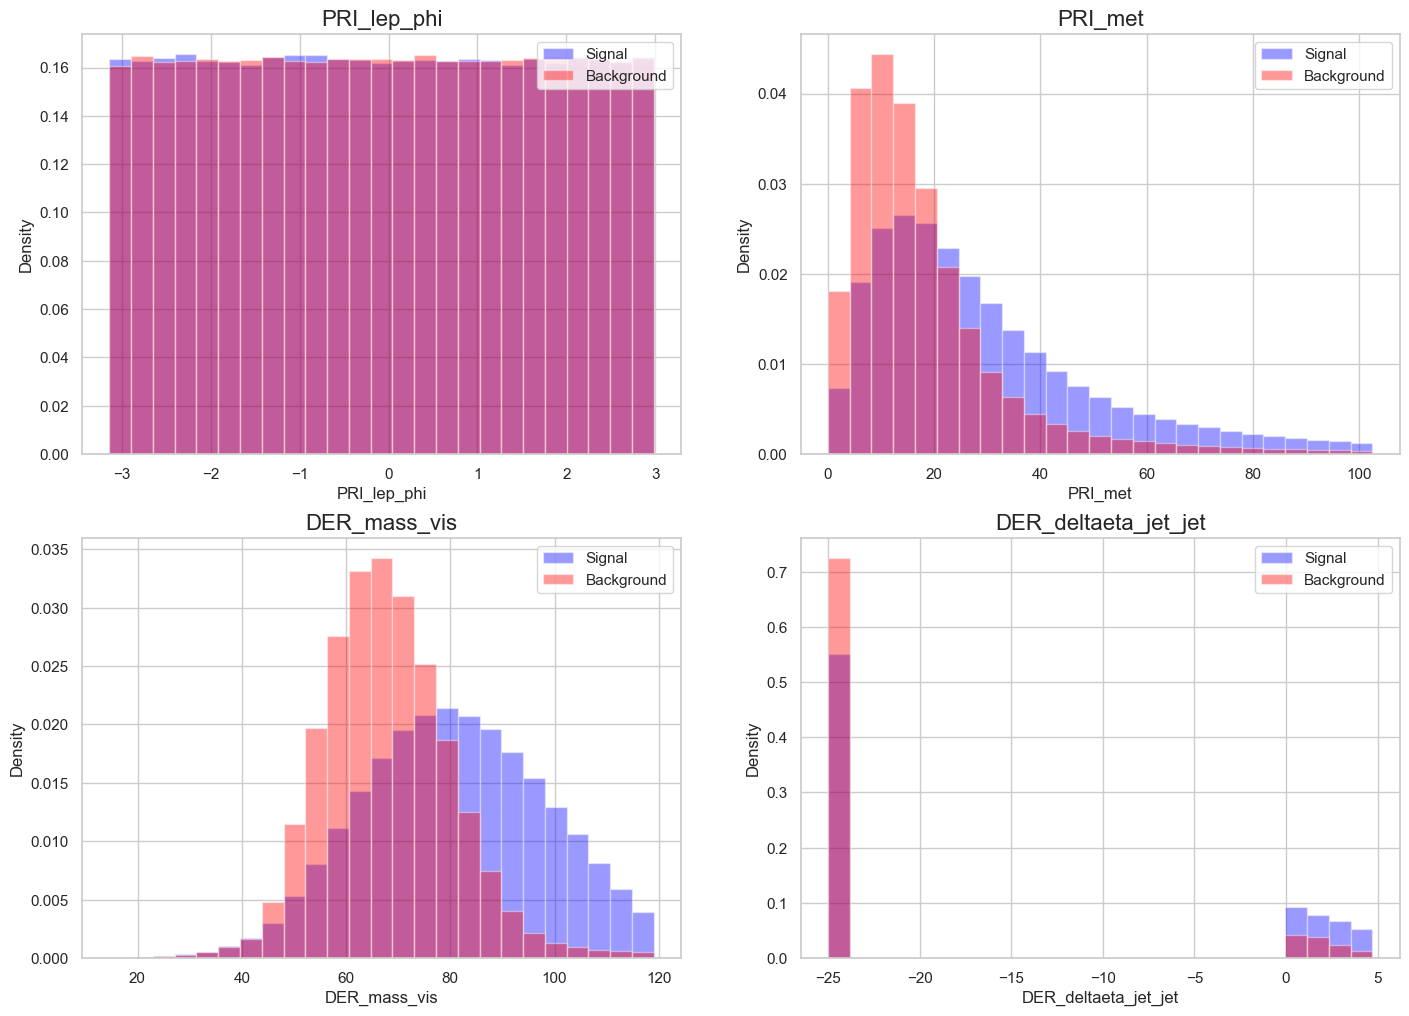

In [12]:
from utils import histogram_dataset

# this function is defined in utils.py in the sample_code_submission directory. feel free to modify it as needed

histogram_dataset(
    data_set,
    target,
    weights,
    columns=["PRI_lep_phi", "PRI_met", "DER_mass_vis", "DER_deltaeta_jet_jet"],
)

Signal feature  correlation matrix


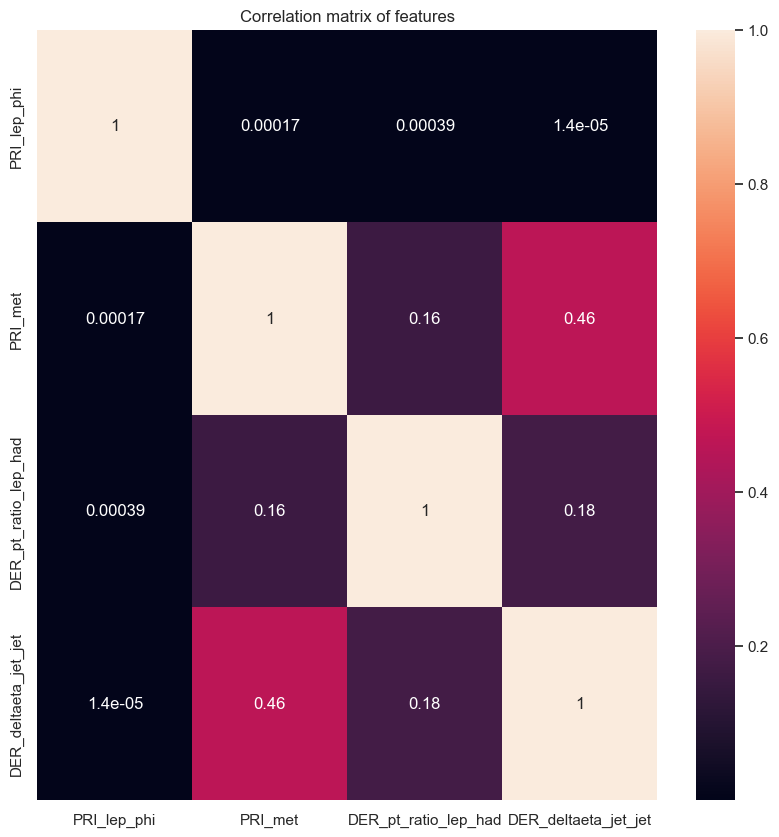

Background feature  correlation matrix


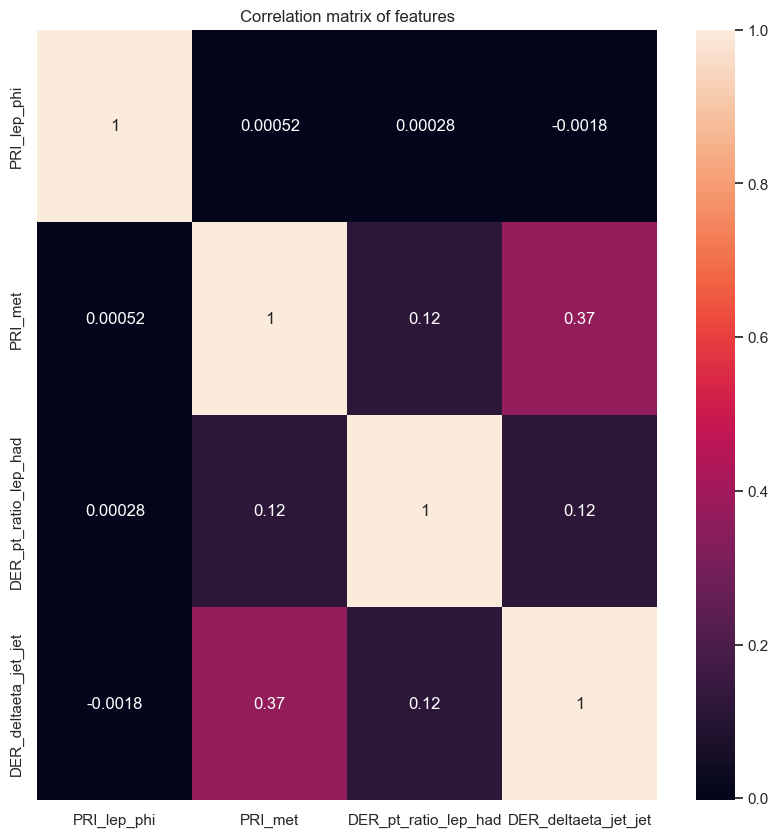

In [13]:
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (10, 10)}, style="whitegrid")

caption = ["Signal feature", "Background feature"]

for i in range(2):

    dfplot = pd.DataFrame(
        data_set,
        columns=[
            "PRI_lep_phi",
            "PRI_met",
            "DER_pt_ratio_lep_had",
            "DER_deltaeta_jet_jet",
        ],
    )

    print(caption[i], " correlation matrix")
    corrMatrix = dfplot[target == i].corr()
    sns.heatmap(corrMatrix, annot=True)
    plt.title("Correlation matrix of features")
    plt.show()

del dfplot

keys ['diboson' 'htautau' 'ttbar' 'ztautau']
keys 2 dict_keys(['diboson', 'htautau', 'ttbar', 'ztautau'])
htautau (30,)


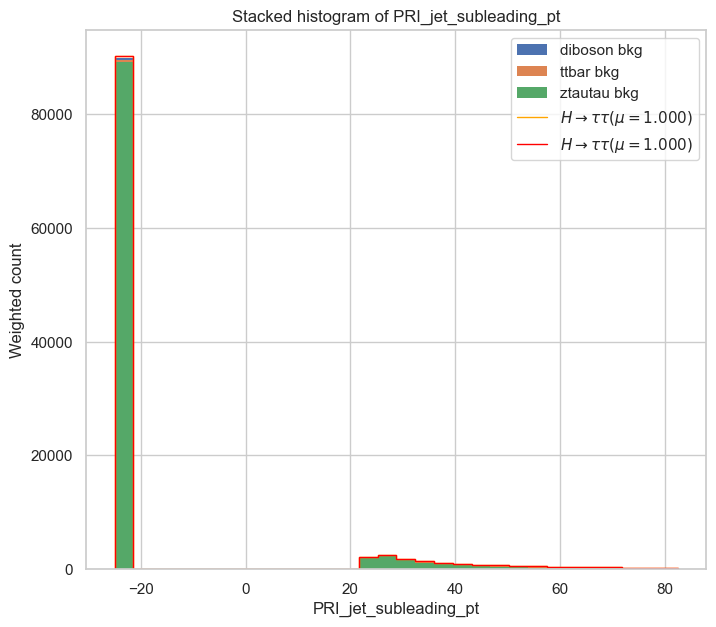

In [14]:
from HiggsML.visualization import stacked_histogram

stacked_histogram(data_set, target, weights, detailed_label, "PRI_jet_subleading_pt")

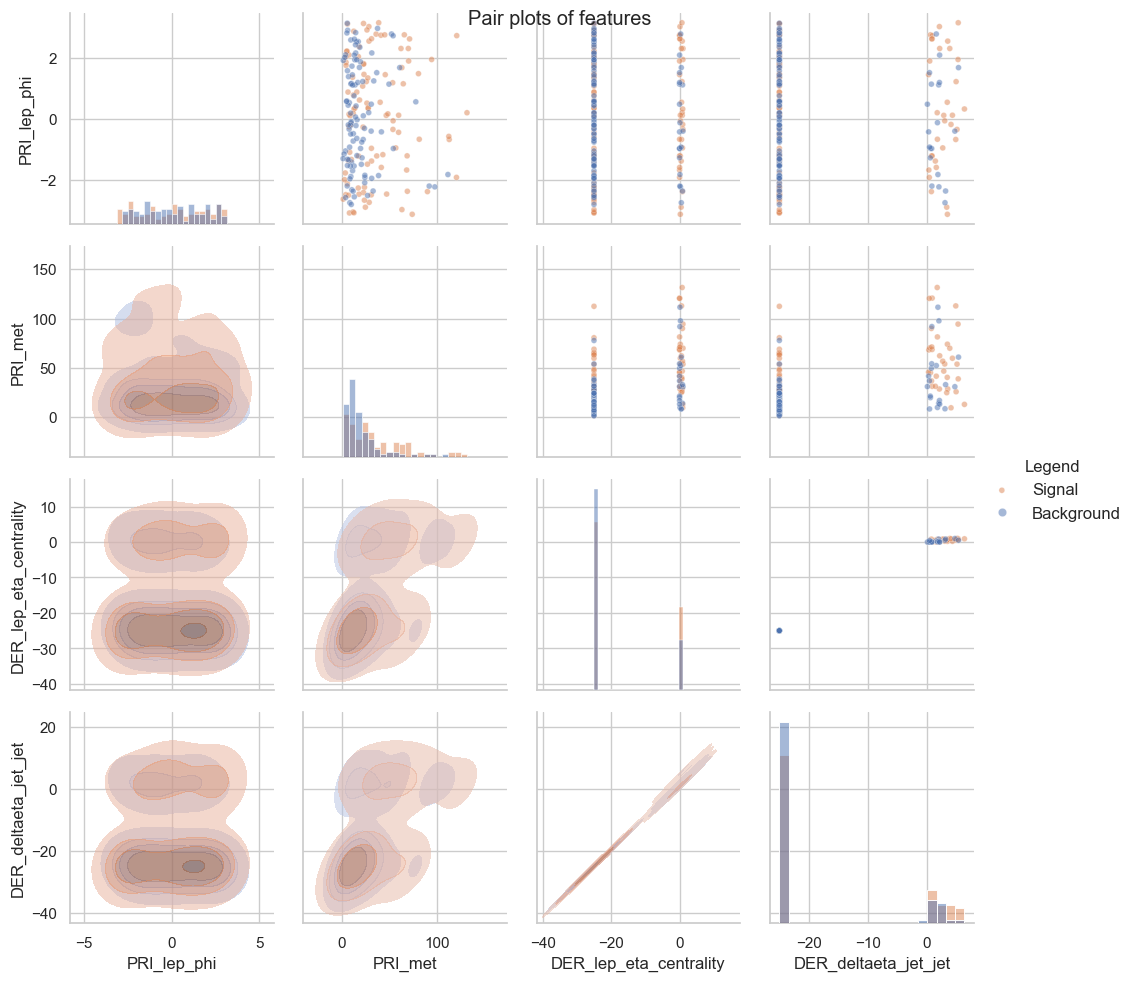

In [15]:
from HiggsML.visualization import pair_plots

# Show data summary
pair_plots(
    data_set,
    target,
    sample_size=100,
    columns=[
        "PRI_lep_phi",
        "PRI_met",
        "DER_lep_eta_centrality",
        "DER_deltaeta_jet_jet",
    ],
)

### Test Settings
The Test setting sets the test conditions in ingestion.
This includes what systematics you want and how many psuedo experiments you want. 

In [16]:
TEST_SETTINGS = {
    "systematics": {  # Systematics to use
        "tes": False,  # tau energy scale
        "jes": False,  # jet energy scale
        "soft_met": False,  # soft term in MET
        "ttbar_scale": False,  # W boson scale factor
        "diboson_scale": False,  # Diboson scale factor
        "bkg_scale": False,  # Background scale factor
    },
    "num_pseudo_experiments": 25,  # Number of pseudo-experiments to run per set
    "num_of_sets": 25,  # Number of sets of pseudo-experiments to run
}

RANDOM_SEED = 42

In [17]:
test_settings = TEST_SETTINGS.copy()

random_state = np.random.RandomState(RANDOM_SEED)
test_settings["ground_truth_mus"] = (
    random_state.uniform(0.1, 3, test_settings["num_of_sets"])
).tolist()

random_settings_file = os.path.join(output_dir, "test_settings.json")
with open(random_settings_file, "w") as f:
    json.dump(test_settings, f)

### Ingestion



In [18]:
from HiggsML.ingestion import Ingestion

ingestion = Ingestion(data)

In [19]:
# initialize submission
ingestion.init_submission(Model)

2025-05-29 12:09:09,590 - HiggsML.ingestion    - INFO     - Initializing Submmited Model
2025-05-29 12:09:09,592 - HiggsML.datasets     - INFO     - Selected train size: 5000
2025-05-29 12:09:09,936 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-05-29 12:09:09,948 - HiggsML.datasets     - INFO     - Selected train size: 5000


Training Data:  (5000, 28)
Training Labels:  (5000,)
Training Weights:  (5000,)
sum_signal_weights:  681.679730244239
sum_bkg_weights:  105037.32026975573


2025-05-29 12:09:10,297 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-05-29 12:09:10,312 - HiggsML.datasets     - INFO     - Selected train size: 5000



Valid Data:  (5000, 28)
Valid Labels:  (5000,)
Valid Weights:  (5000,)
sum_signal_weights:  671.3365715098221
sum_bkg_weights:  105047.66342849021


2025-05-29 12:09:10,657 - HiggsML.datasets     - INFO     - Data loaded successfully



Holdout Data:  (5000, 28)
Holdout Labels:  (5000,)
Holdout Weights:  (5000,)
sum_signal_weights:  648.5987569269887
sum_bkg_weights:  105070.40124307296
 
 
Training Data:  (5000, 28)
 Model is Sample Model


2025-05-29 12:09:10,702 - HiggsML.ingestion    - INFO     - Calling fit method of submitted model


score shape before threshold (4574,)
score shape after threshold (4574,)
saved_info {'beta': np.float64(94628.01905013468), 'gamma': np.float64(612.6940988245049), 'tes_fit': <function tes_fitter.<locals>.fit_function at 0x0000027E041FAA20>, 'jes_fit': <function jes_fitter.<locals>.fit_function at 0x0000027E0D185580>}
Train Results: 
	 mu_hat  :  1.0455462838324419
	 del_mu_stat  :  0.5036949792522856
	 del_mu_sys  :  0.0
	 del_mu_tot  :  0.5036949792522856
Holdout Results: 
	 mu_hat  :  0.9999999999999989
	 del_mu_stat  :  0.5036949792522856
	 del_mu_sys  :  0.0
	 del_mu_tot  :  0.5036949792522856
Valid Results: 
	 mu_hat  :  0.5568371306481116
	 del_mu_stat  :  0.5036949792522856
	 del_mu_sys  :  0.0
	 del_mu_tot  :  0.5036949792522856
[*] --- score histogram


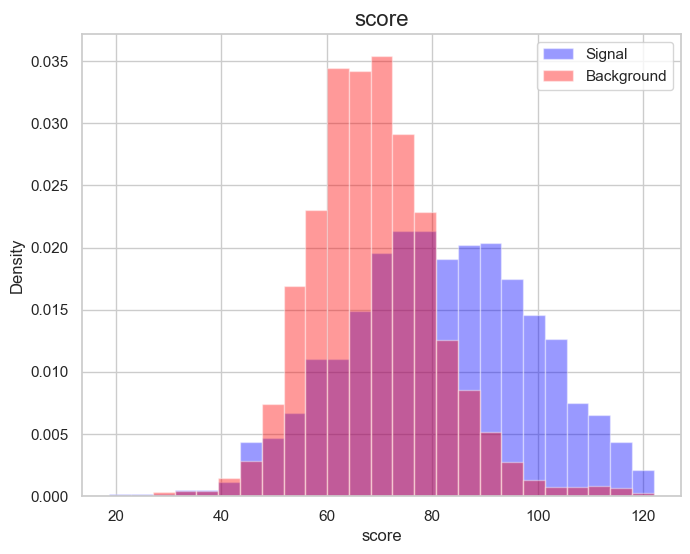

keys ['diboson' 'htautau' 'ttbar' 'ztautau']
keys 2 dict_keys(['diboson', 'htautau', 'ttbar', 'ztautau'])
htautau (30,)


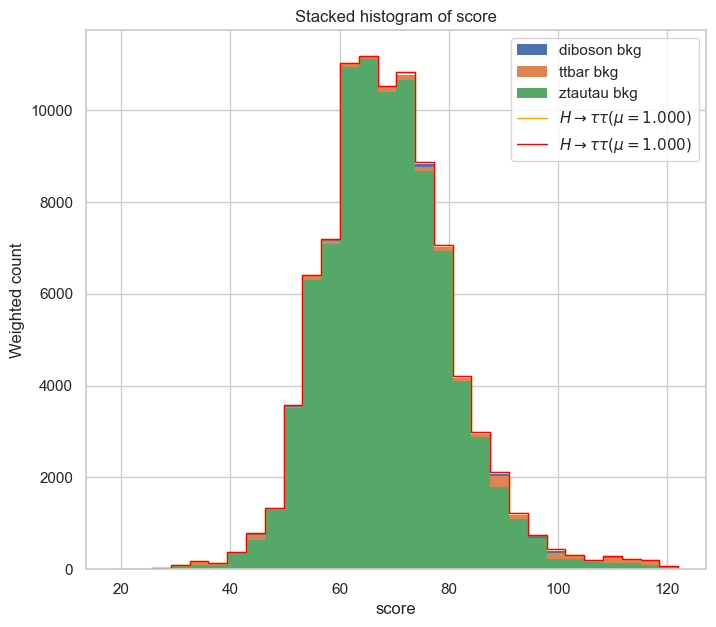

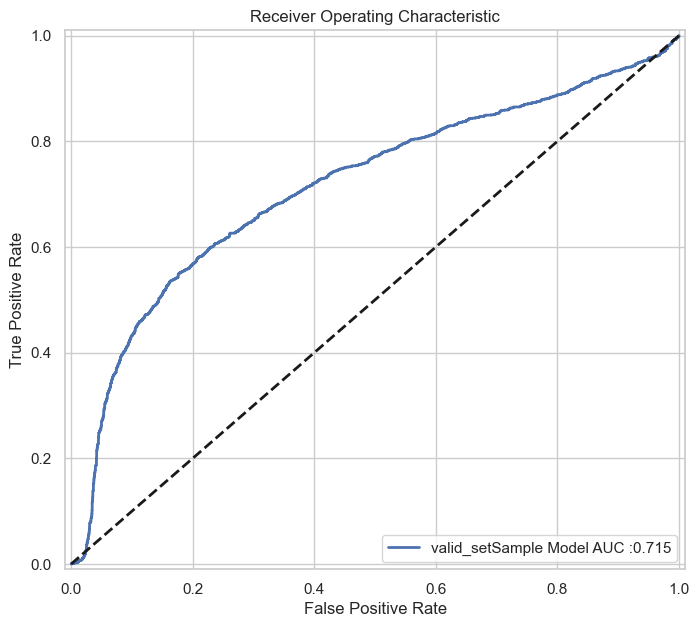

In [20]:
# fit submission
ingestion.fit_submission()

In [21]:
# load test set
data.load_test_set()

2025-05-29 12:09:12,382 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-05-29 12:09:12,665 - HiggsML.datasets     - INFO     - Test data loaded successfully


In [22]:
# predict submission
ingestion.predict_submission(test_settings)

2025-05-29 12:09:12,686 - HiggsML.ingestion    - INFO     - Calling predict method of submitted model with seed: 31415


Test Results:  {'mu_hat': np.float64(2.128274047958182), 'del_mu_stat': np.float64(0.5036949792522856), 'del_mu_sys': np.float64(0.0), 'del_mu_tot': np.float64(0.5036949792522856)}
Test Results:  {'mu_hat': np.float64(0.9058043009229042), 'del_mu_stat': np.float64(0.5036949792522856), 'del_mu_sys': np.float64(0.0), 'del_mu_tot': np.float64(0.5036949792522856)}
Test Results:  {'mu_hat': np.float64(2.890481487030912), 'del_mu_stat': np.float64(0.5036949792522856), 'del_mu_sys': np.float64(0.0), 'del_mu_tot': np.float64(0.5036949792522856)}
Test Results:  {'mu_hat': np.float64(1.8736608563193258), 'del_mu_stat': np.float64(0.5036949792522856), 'del_mu_sys': np.float64(0.0), 'del_mu_tot': np.float64(0.5036949792522856)}
Test Results:  {'mu_hat': np.float64(1.0690178853067864), 'del_mu_stat': np.float64(0.5036949792522856), 'del_mu_sys': np.float64(0.0), 'del_mu_tot': np.float64(0.5036949792522856)}
Test Results:  {'mu_hat': np.float64(3.7848919294545866), 'del_mu_stat': np.float64(0.503694

In [23]:
ingestion.process_results_dict()

In [24]:
# save result
ingestion.save_result(output_dir)

## Score
1. Compute Scores
2. Visualize Scores


In [25]:
from HiggsML.score import Scoring

In [26]:
# Initialize Score
score = Scoring()

In [27]:
print(output_dir)
score.load_ingestion_results(prediction_dir=output_dir, score_dir=output_dir)

d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission


2025-05-29 12:11:49,590 - HiggsML.score        - INFO     - Read ingestion results from d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission


2025-05-29 12:11:49,601 - HiggsML.score        - INFO     - Computing scores
c:\Users\Ragansu_User\AppData\Local\Programs\Python\Python313\Lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\Ragansu_User\AppData\Local\Programs\Python\Python313\Lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\Ragansu_User\AppData\Local\Programs\Python\Python313\Lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.1

[✔]


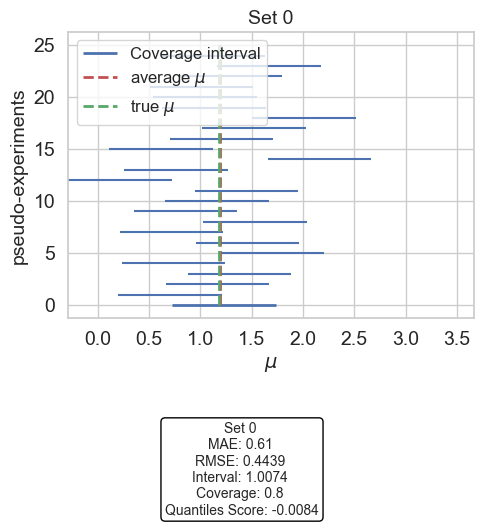

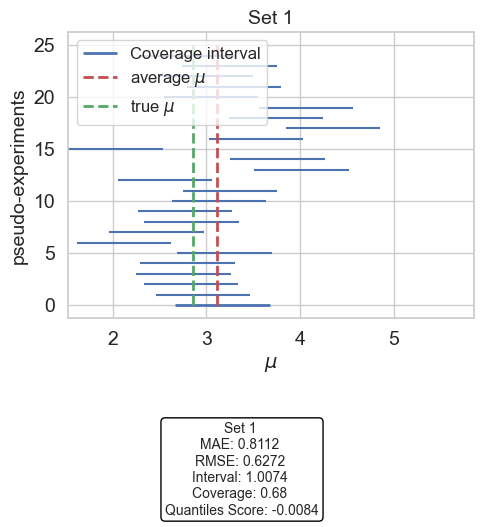

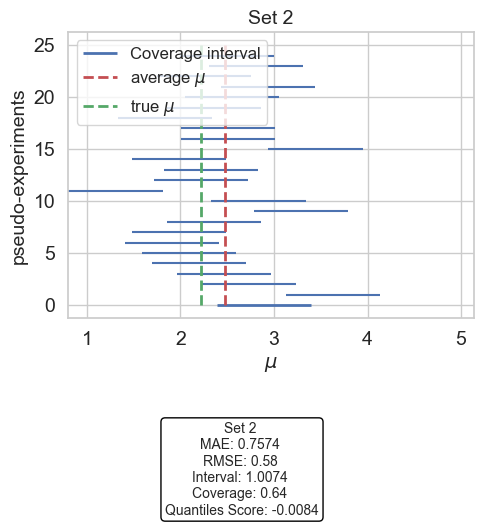

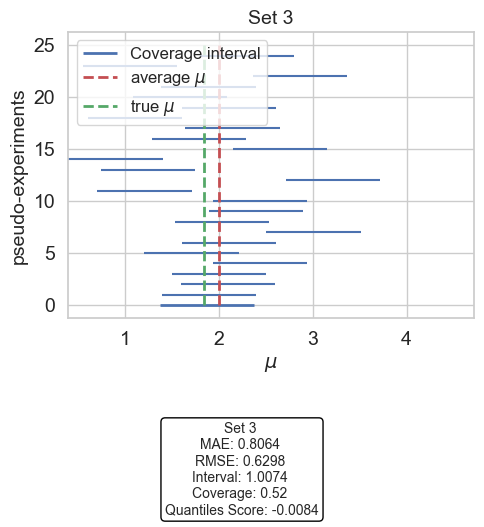

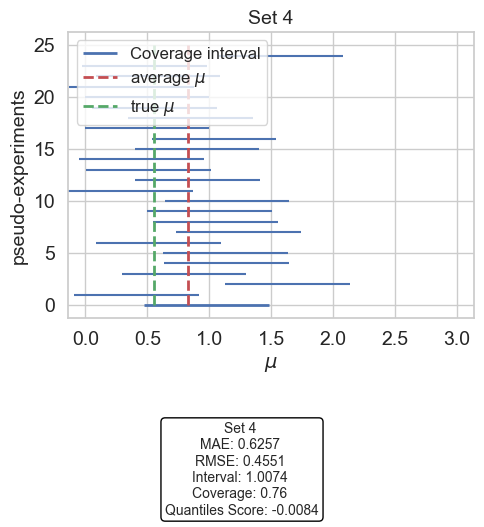

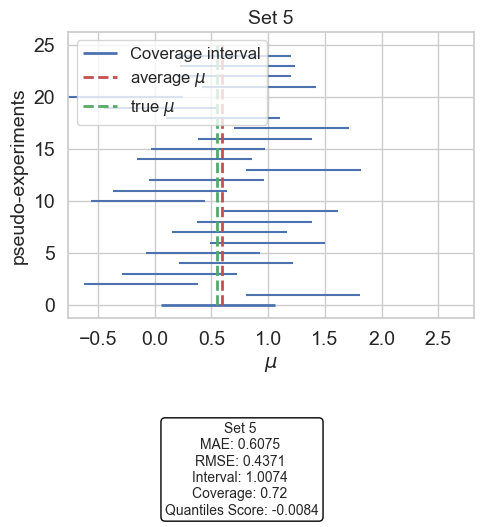

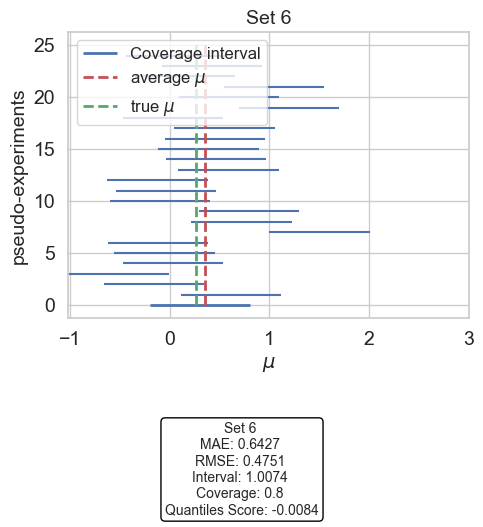

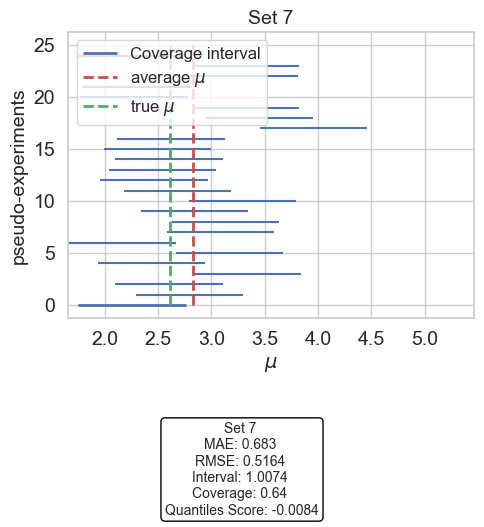

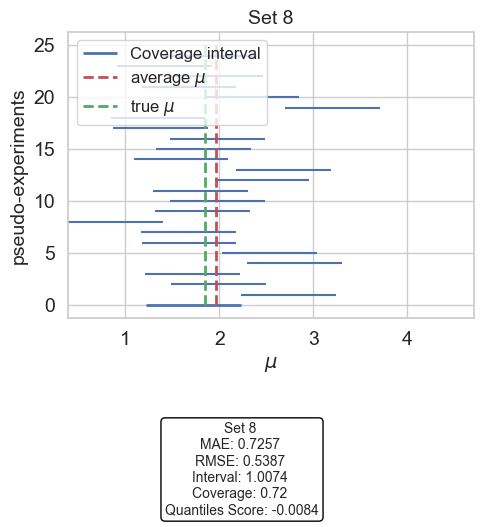

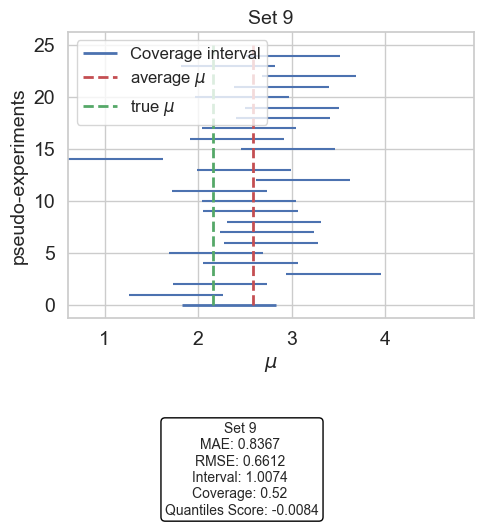

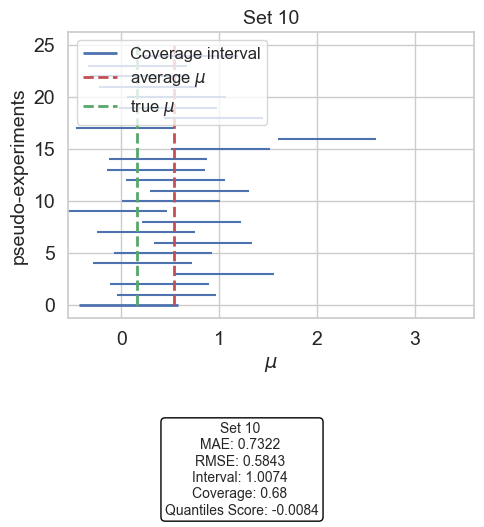

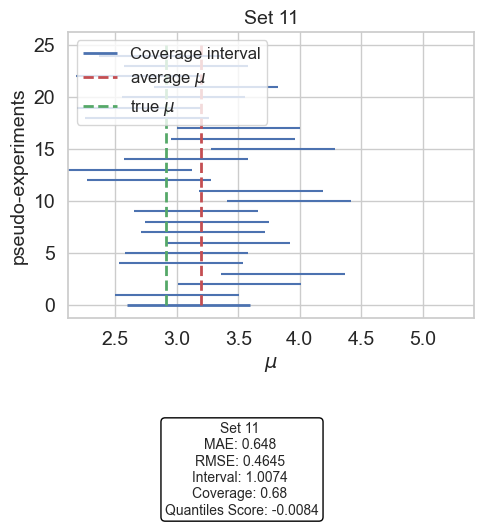

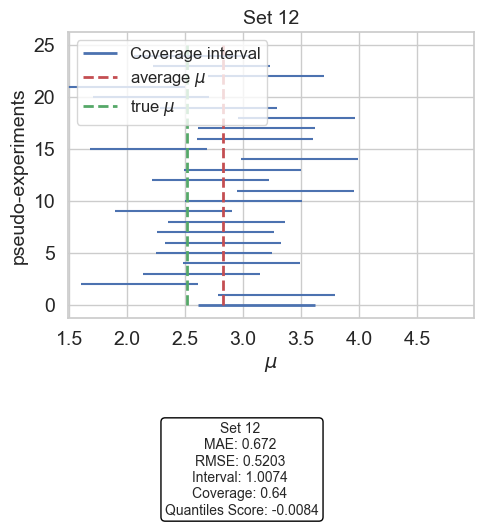

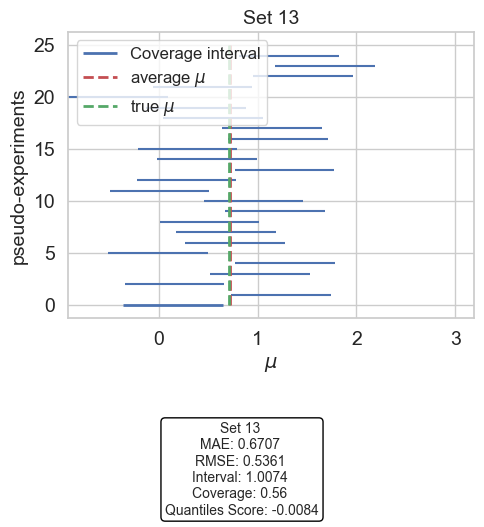

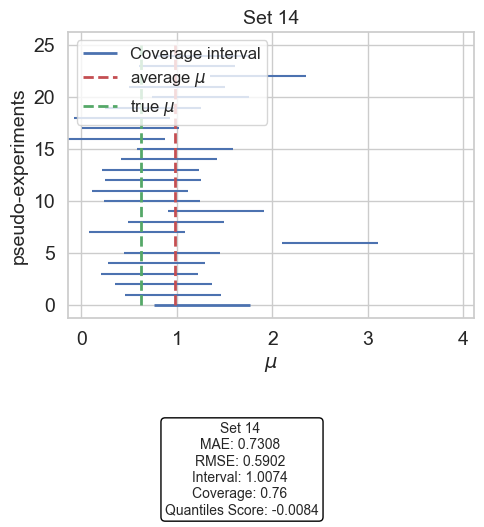

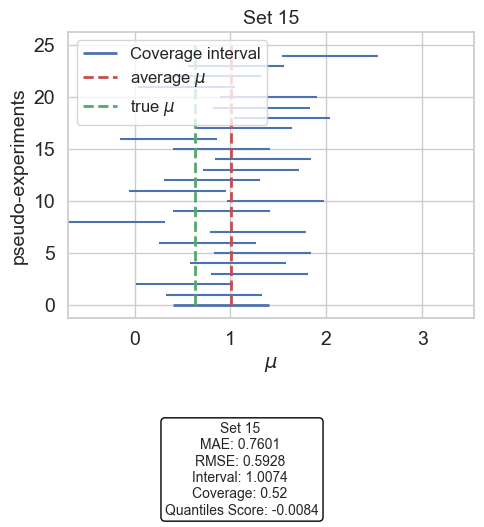

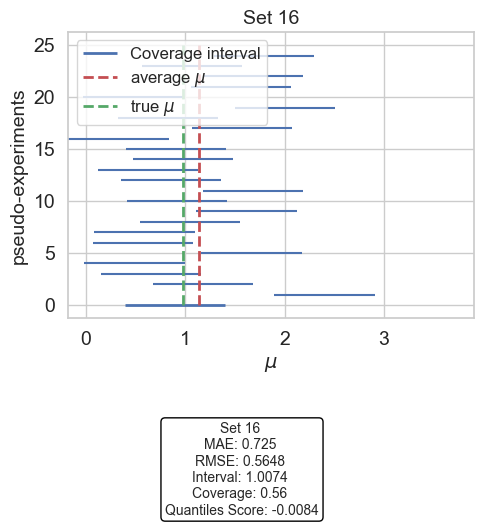

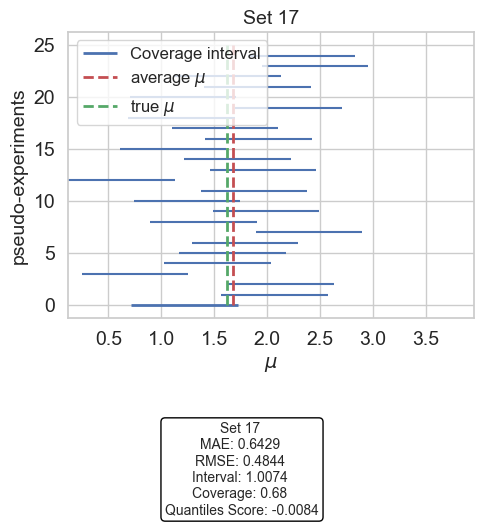

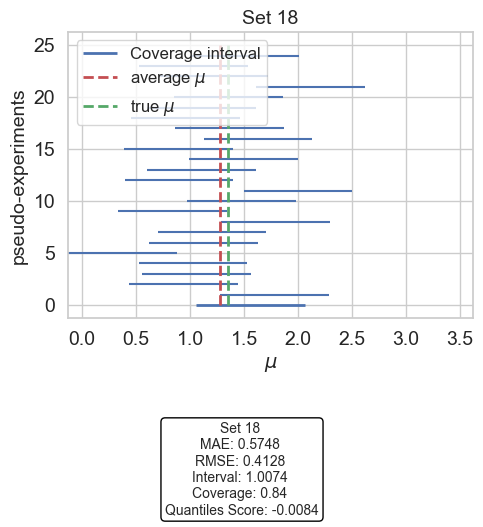

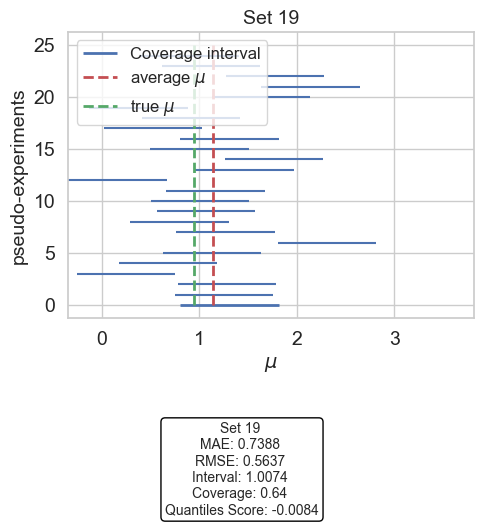

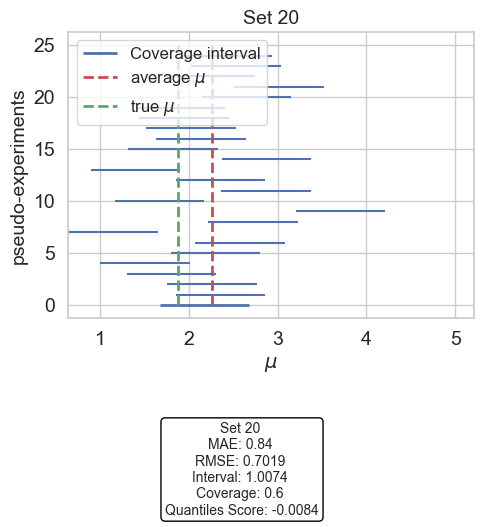

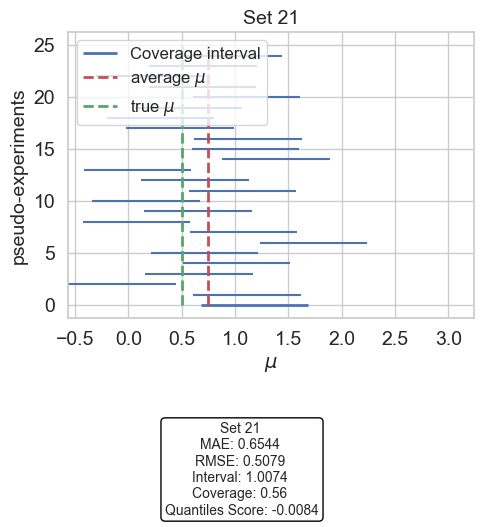

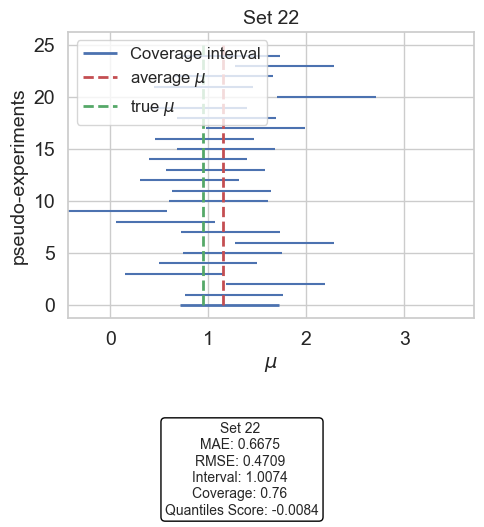

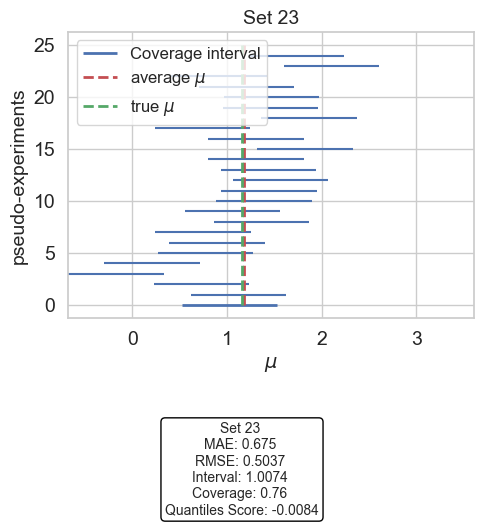

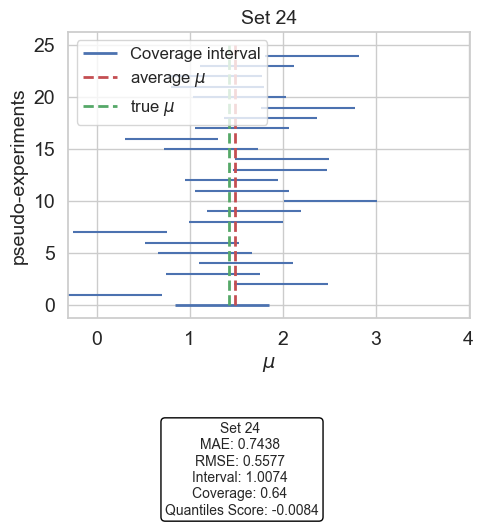

In [28]:
# Compute Score
score.compute_scores(test_settings)

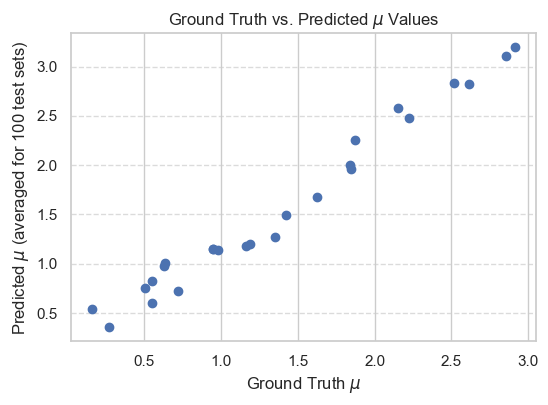

In [29]:
from HiggsML.visualization import visualize_scatter

# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(
    ingestion_result_dict=ingestion.results_dict,
    ground_truth_mus=test_settings["ground_truth_mus"],
)

In [30]:
!python -m HiggsML.score --prediction $output_dir --output $output_dir

############################################
### Scoring Program
############################################

d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission\test_settings.json
d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission
[✔]

----------------------------------------------
[✔] Scoring Program executed successfully!
----------------------------------------------




2025-05-29 12:11:59,777 - HiggsML.score        - INFO     - Reading ingestion duration from d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission\ingestion_duration.json
2025-05-29 12:11:59,777 - HiggsML.score        - WARNING  - File d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission\ingestion_duration.json not found. Setting ingestion duration to 0.
2025-05-29 12:11:59,782 - HiggsML.score        - INFO     - Read ingestion results from d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission
2025-05-29 12:11:59,782 - HiggsML.score        - INFO     - Computing scores
c:\Users\Ragansu_User\AppData\Local\Programs\Python\Python313\Lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\Ragansu_User\AppData\Local\P